<a href="https://colab.research.google.com/github/emylincon/GridProject/blob/master/EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cd "drive/MyDrive/dataset/"
! ls "drive/MyDrive/dataset/"

bimodel  my_model.h5  test  train


In [ ]:
! pip3 install keras==2.3.1

     |████████████████████████████████| 378kB 5.8MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


# USING EfficientNetB7

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

HEIGHT = 300
WIDTH = 300

base_model = EfficientNetB7(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
import os
os.chdir('drive/MyDrive/dataset/')
print(os.getcwd())

/content/drive/MyDrive/dataset


# DATA PREPROCESSING AND AUGMENTATION

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "train/"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        'test/',
        target_size=(300, 300),
        batch_size=BATCH_SIZE)

Found 374 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


# BUILDING MODEL

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = os.listdir("train/")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

# COMPLILE AND TRAIN MODEL

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 30
BATCH_SIZE = 16
num_train_images = 370

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="../eff_checkpoint/" + "EFF" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=16, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7967
Epoch 00001: saving model to ../eff_checkpoint/EFF_model_weights.h5
23/23 [==============================] - 221s 10s/step - loss: 0.5071 - accuracy: 0.7967
Epoch 2/30
 3/23 [==>...........................] - ETA: 2:17 - loss: 0.4727 - accuracy: 0.7500

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


23/23 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8315
Epoch 00002: saving model to ../eff_checkpoint/EFF_model_weights.h5
23/23 [==============================] - 235s 10s/step - loss: 0.4824 - accuracy: 0.8315
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.8242
Epoch 00003: saving model to ../eff_checkpoint/EFF_model_weights.h5
23/23 [==============================] - 249s 11s/step - loss: 0.5485 - accuracy: 0.8242
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.8478
Epoch 00004: saving model to ../eff_checkpoint/EFF_model_weights.h5
23/23 [==============================] - 248s 11s/step - loss: 0.4875 - accuracy: 0.8478
Epoch 5/30
23/23 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8681
Epoch 00005: saving model to ../eff_checkpoint/EFF_model_weights.h5
23/23 [==============================] - 252s 11s/step - loss: 0.3957 - accuracy: 0.8681
Epoch 6

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
history.history['accuracy'][-1]

0.9120879173278809

In [ ]:
predictions1 = finetune_model.predict(x=validation_generator, verbose=0)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
cm = confusion_matrix(y_true=validation_generator.classes, y_pred=np.argmax(predictions1, axis=-1))

In [ ]:
cm

array([[29, 16],
       [22, 23]])

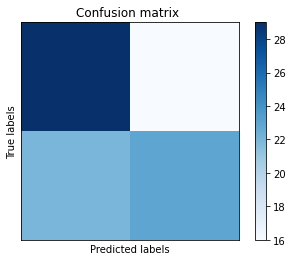

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [ ]:
finetune_model.evaluate(validation_generator)

12/12 [==============================] - 87s 7s/step - loss: 0.4983 - accuracy: 0.8889


[0.4983006715774536, 0.8888888955116272]

In [ ]:
validation_generator.class_indices

{'ec': 0, 'nec': 1}

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
def get_prediction(image_path):
  names = ['EC', 'NEC']
  img = load_img(image_path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = finetune_model.predict(x)
  return names[preds.argmax()]

In [ ]:
base_ec = 'test/ec/'
ecs = os.listdir(base_ec)
err = []
for i in ecs:
  if get_prediction(base_ec+i) == 'NEC':
    err.append(i)

print(err)

['000206.jpg', '000210.jpg', '000231.jpg', '000189.jpg']


In [ ]:
base_nec = 'test/nec/'
necs = os.listdir(base_nec)
err = []
for i in necs:
  if get_prediction(base_nec+i) == 'EC':
    err.append(i)

print(err)

['000210.jpg', '000204.jpg', '000216.jpg', '000197.jpg', '000213.jpg', '000209.jpg', '000219.jpg', '000211.jpg']


In [ ]:
finetune_model.save('eff1_model.h5')